In [1]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, savgol_filter 
from scipy.ndimage import uniform_filter1d


from astropy.stats import median_absolute_deviation as MAD


In [2]:
# #plots layout
from matplotlib import rc
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager
import matplotlib.colors as colors


plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18


SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


In [3]:
folder = "Data/Additional_EIRPs"  # Change this to your actual folder path
files = glob.glob(os.path.join(folder, "*.csv"))

# Dictionary to store each instrument's data
data = {}

for file in files:
    # Get file base name without extension (e.g., camera, radio)
    label = os.path.splitext(os.path.basename(file))[0]
    
    # Load CSV into a DataFrame
    df = pd.read_csv(file)
    
    # Store in the dictionary
    data[label] = df

In [4]:
camera = data['2020_02_11_INCA_Camera_100kHz_EIRP']
bakkie = data['ALS_Bakkie_CAA567123_100kHz_EIRP']
radio = data['Kiricom_Radio_On_MAX_100kHz_EIRP']
headlamp = data['Superfire_HL58_Headlamp_100kHz_EIRP']

bakkie.items

<bound method DataFrame.items of       Frequency(MHz)  EIRP(dBm)  BG_EIRP(dBm) 
0         100.440000 -69.390840     -70.060840
1         101.413333 -69.248062     -70.638062
2         102.386667 -65.854705     -65.594705
3         103.360000 -68.839424     -70.869424
4         104.333333 -69.714813     -70.534813
...              ...        ...            ...
2974     2995.133333 -56.694552     -57.594552
2975     2996.106667 -56.376291     -57.566291
2976     2997.080000 -56.398307     -58.108307
2977     2998.053333 -57.430704     -57.610704
2978     2999.026667 -57.264256     -57.974256

[2979 rows x 3 columns]>

# Removing the backgroup noise form the signal

In [5]:
def bg_remove(signal, background):
     """
    Args:
    signal: mesurements of the instrument + noise
    background: mesurement of the background

    Return:
    clean_signal: signal of the instrument
    """
     
    # convert log scale to linear scale
     signal_mW = 10**(signal/10)
     background_mW = 10**(background/10)

    # Subtract background in linear scale
     clean_mW = signal_mW - background_mW
     clean_mW[clean_mW <= 0] = np.nan

    # Convert back to dBm
     clean_signal = 10 * np.log10(clean_mW)

     return clean_signal



In [6]:
clean_camera =bg_remove(camera['EIRP(dBm)'],camera['BG_EIRP(dBm)'])
clean_bakkie =bg_remove(bakkie['EIRP(dBm)'],bakkie['BG_EIRP(dBm) '])
clean_radio =bg_remove(radio['EIRP(dBm)'],radio['BG_EIRP(dBm)'])
clean_headlamp =bg_remove(headlamp['EIRP(dBm)'],headlamp['BG_EIRP(dBm)'])
print(clean_camera)

0       -89.993994
1       -89.680630
2       -86.307727
3       -84.477517
4       -87.773224
           ...    
63996          NaN
63997          NaN
63998          NaN
63999          NaN
64000   -80.444687
Length: 64001, dtype: float64


# Determine the best polynomial order for the data

In [7]:
def bic(freq,signal):
    """
    Args:
    signal: signal of the instrument
    freq: frequecny domain

    Return:
    BIC_values
    """
    # Range of polynomial degrees to test
    degrees = range(1, 25)
    bics = []

    n = len(freq)

    for deg in degrees:
        #Fit the polynomial
        coeffs = np.polyfit(freq,signal,deg)
        y_fit = np.polyval(coeffs,freq)

        # Residual Sum of Square
        residuals = signal - y_fit
        rss = np.sum(residuals**2)

        # Bic calculation
        k = deg + 1 # Number of parameters in polynomial
        bic = n*np.log(rss/n)+k*np.log(n)
        bics.append(bic)

        
    return bics, degrees

In [8]:

def calculate_bic(frequencies, signal, max_degree):
    """
    Calculate BIC values for polynomial fits of varying degrees
    
    Parameters:
    - frequencies: array-like, input frequency values
    - signal: array-like, signal power values
    - max_degree: int, maximum polynomial degree to test 
    
    Returns:
    - bics: list of BIC values for degrees 1..max_degree
    - optimal_degree: degree with minimum BIC
    """

    degrees = range(1, max_degree + 1)
    bics = []
    n = len(frequencies)
    
    for deg in degrees:
        # Fit polynomial
        coeffs = np.polyfit(frequencies, signal, deg)
        y_fit = np.polyval(coeffs, frequencies)
        
        # Residual sum of squares
        residuals = signal - y_fit
        rss = np.sum(residuals ** 2)
        
        # BIC calculation
        k = deg + 1  # Number of parameters
        bic = n * np.log(rss / n) + k * np.log(n)
        bics.append(bic)
    
    
    return bics, degrees

/tmp/ipykernel_3919/795218766.py:1: RankWarning: Polyfit may be poorly conditioned
  bic_camera, degre_camera = calculate_bic(camera['Frequency(MHz)'],camera['BG_EIRP(dBm)'],50)
/tmp/ipykernel_3919/795218766.py:1: RankWarning: Polyfit may be poorly conditioned
  bic_camera, degre_camera = calculate_bic(camera['Frequency(MHz)'],camera['BG_EIRP(dBm)'],50)
/tmp/ipykernel_3919/795218766.py:1: RankWarning: Polyfit may be poorly conditioned
  bic_camera, degre_camera = calculate_bic(camera['Frequency(MHz)'],camera['BG_EIRP(dBm)'],50)
/tmp/ipykernel_3919/795218766.py:1: RankWarning: Polyfit may be poorly conditioned
  bic_camera, degre_camera = calculate_bic(camera['Frequency(MHz)'],camera['BG_EIRP(dBm)'],50)
/tmp/ipykernel_3919/795218766.py:1: RankWarning: Polyfit may be poorly conditioned
  bic_camera, degre_camera = calculate_bic(camera['Frequency(MHz)'],camera['BG_EIRP(dBm)'],50)
/tmp/ipykernel_3919/795218766.py:1: RankWarning: Polyfit may be poorly conditioned
  bic_camera, degre_camera 

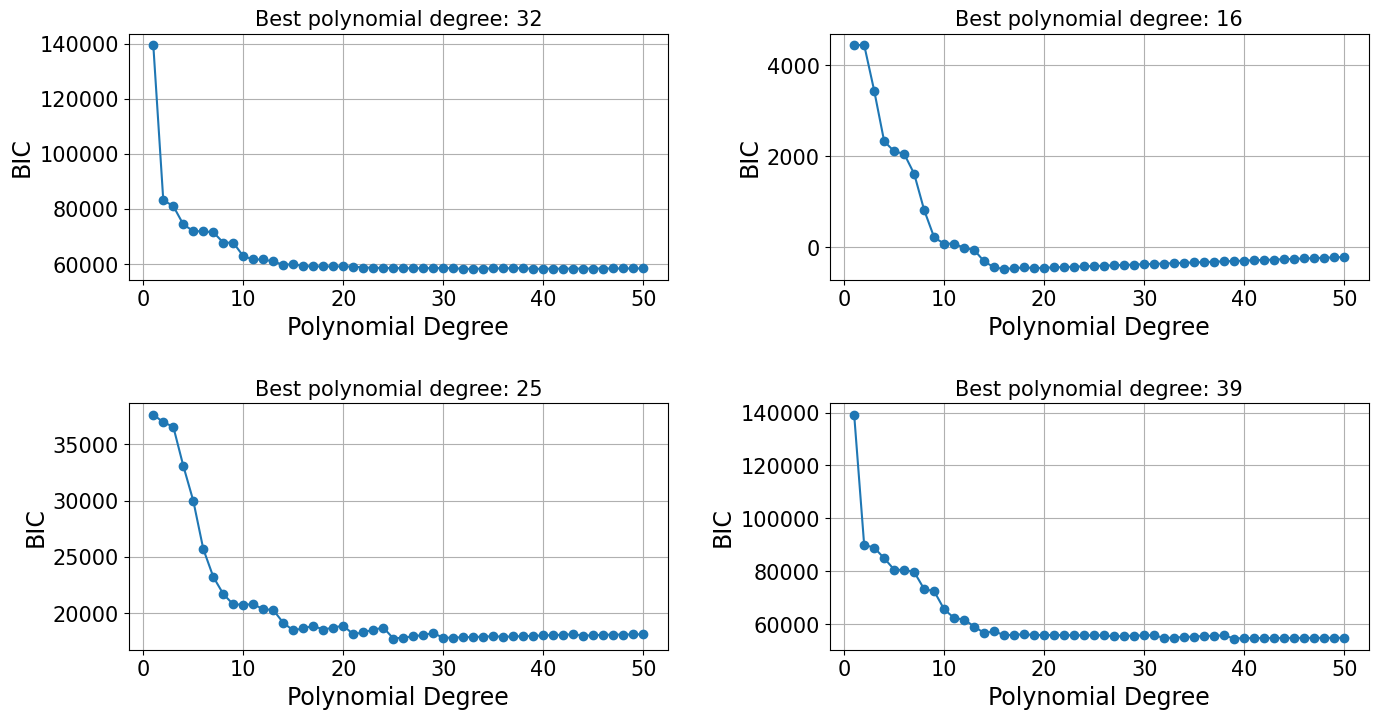

In [10]:
bic_camera, degre_camera = calculate_bic(camera['Frequency(MHz)'],camera['BG_EIRP(dBm)'],50)
bic_bakkie, degre_bakkie = calculate_bic(bakkie['Frequency(MHz)'],bakkie['BG_EIRP(dBm) '],50)
bic_radio,degre_radio = calculate_bic(radio['Frequency(MHz)'],radio['BG_EIRP(dBm)'],50)
bic_headlamp, degre_headlamp = calculate_bic(headlamp['Frequency(MHz)'],headlamp['BG_EIRP(dBm)'],50)




# Plot BIC vs. degree
fig, axs = plt.subplots(2,2, figsize=(16,8))
fig.subplots_adjust(wspace=0.3, hspace=0.5)

# Find optimal degree camera
optimal_idx_camera = np.argmin(bic_camera)
optimal_degree_camera = degre_camera[optimal_idx_camera]

axs[0,0].plot(degre_camera, bic_camera, marker="o")
axs[0,0].set_title(f"Best polynomial degree: {optimal_degree_camera}")
axs[0,0].set_xlabel("Polynomial Degree")
axs[0,0].set_ylabel("BIC")
axs[0,0].grid(True)


# Find optimal degree bakkie
optimal_idx_bakkie = np.argmin(bic_bakkie)
optimal_degree_bakkie = degre_bakkie[optimal_idx_bakkie]

axs[0,1].plot(degre_bakkie, bic_bakkie, marker="o")
axs[0,1].set_title(f"Best polynomial degree: {optimal_degree_bakkie}")
axs[0,1].set_xlabel("Polynomial Degree")
axs[0,1].set_ylabel("BIC")
axs[0,1].grid(True)


# Find optimal degree
optimal_idx_radio = np.argmin(bic_radio)
optimal_degree_radio = degre_radio[optimal_idx_radio]

axs[1,0].plot(degre_radio, bic_radio, marker="o")
axs[1,0].set_title(f"Best polynomial degree: {optimal_degree_radio}")
axs[1,0].set_xlabel("Polynomial Degree")
axs[1,0].set_ylabel("BIC")
axs[1,0].grid(True)


# Find optimal degree
optimal_idx_headlamp = np.argmin(bic_headlamp)
optimal_degree_headlamp = degre_camera[optimal_idx_headlamp]

axs[1,1].plot(degre_headlamp, bic_headlamp, marker="o")
axs[1,1].set_title(f"Best polynomial degree: {optimal_degree_headlamp}")
axs[1,1].set_xlabel("Polynomial Degree")
axs[1,1].set_ylabel("BIC")
axs[1,1].grid(True)



# Define the best windou legth for Savitxky-Golay filter.

In [11]:

def window_length(freq, signal):
    """
    Analyze different window lenght to use Savitzky-Golay filters.
    
    Parameters:
        freq (array): Frequency values
        signal (array): Signal values to analyze
        
    Returns:
        tuple: (trends, detrended_signals) containing all filtered results
    """
    
    # Configuration
    windows = [11, 21, 31]
    polyorder = 3
    colors = ['blue', 'orange', 'green']
    titles = ['Detrended (W=11)', 'Detrended (W=21)', 'Detrended (W=31)']
    
    # Calculate trends and detrended signals
    trends = []
    dets = []
    
    for w in windows:
        try:
            trend = savgol_filter(signal, window_length=w, polyorder=polyorder)
            det = signal - trend
            trends.append(trend)
            dets.append(det)
        except ValueError as e:
            print(f"Error with window size {w}: {str(e)}")
            continue
    
    # Create figure and axes
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Savitzky-Golay Filter Analysis', fontsize=14, y=1.02)
    
    # Plot original signal with all trends
    axs[0,0].plot(freq, signal, label="Original Signal", color='black', alpha=0.8, linewidth=1.5)
    for i, (w, trend, color) in enumerate(zip(windows, trends, colors)):
        axs[0,0].plot(freq, trend, label=f"window = {w}", alpha=0.8, color=color)
    axs[0,0].legend()
    axs[0,0].grid(True, linestyle='--', alpha=0.6)
    axs[0,0].set_title('Signal with Different SG Filters')
    axs[0,0].set_xlabel('Frequency')
    axs[0,0].set_ylabel('Amplitude')
    
    # Plot detrended signals
    for i, (ax, det, color, title) in enumerate(zip(
        [axs[0,1], axs[1,0], axs[1,1]], 
        dets, 
        colors, 
        titles
    )):
        ax.plot(freq, det, color=color, alpha=0.8)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_title(title)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Detrended Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    return trends, dets

In [12]:
# camera

# Parameters
windows = [11, 21, 31, 41, 51]
polyorder = 3

# Create all filtered trends in one loop
trends = [savgol_filter(clean_camera, window_length=w, polyorder=polyorder) for w in windows]
dets = [clean_camera - trend for trend in trends]



# Identify peaks

In [13]:
def peaks_detection(signal,h,p,d):
    """
    Parameter:
    signal (array): detrended signal
    h (int): minimum value of the peaks(STD or MAD)
    p (int): how much apeaj stands out form surrounding
    d (int): minimum number os samples between peaks
    
    Retur:
    peaks(array): amplitude of the peaks detetcted
    """

    peak, _ = find_peaks(signal,
                         height=h,
                         prominence=p,
                         distance=d)
    
    return peak